In [1]:
import os
import torch
import timm
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
 
# Define the defect classifier model
class DefectClassifier(nn.Module):
    def __init__(self, pretrained_model):
        super(DefectClassifier, self).__init__()
        self.branch1 = nn.Sequential(
            pretrained_model,
            nn.Linear(1000, 2)  # Binary classification: defect or no defect
        )

        self.branch2 = nn.Sequential(
            pretrained_model,
            nn.Linear(1000, 23)  # Multi-class classification: 23 defect types
        )
 
    def forward(self, x):
        def resize_segment(segment):
            return nn.functional.interpolate(segment, size=(224, 224), mode='bilinear', align_corners=False)
 
        _, _, height, width = x.shape

        if height == 960 and width == 1440:
            # Split and resize for branches
            first_4_segments = resize_segment(x[:, :, :960, :960])
            last_2_segments = resize_segment(x[:, :, :960, 960:])

            out1 = self.branch1(first_4_segments)
            out2 = self.branch2(last_2_segments)

            return out1, out2

        elif height == 1440 and width == 1440:  # Handle 7-segment images
            optical_segment = resize_segment(x[:, :, 960:1440, :480])  # 7th segment (bottom-left)

            out1 = torch.zeros(x.size(0), 2).to(x.device)  # No defect detected
            out2 = torch.full((x.size(0), 23), -float('inf')).to(x.device)

            out2[:, 0] = 0  # SEM_NON_VISIBLE class

            return out1, out2

        else:
            raise ValueError(f"Unexpected image dimensions: {height}x{width}")
 
# Load the pretrained ConViT model
pretrained_model = timm.create_model('convit_base', pretrained=False, num_classes=1000)
state_dict = torch.load('./convit_base.fb_in1k/pytorch_model.bin', map_location=torch.device('cpu'))
pretrained_model.load_state_dict(state_dict)
 
# Initialize and load the trained model
model = DefectClassifier(pretrained_model)
model.load_state_dict(torch.load("model_new.pth", map_location=torch.device('cpu')))
model.eval()

DefectClassifier(
  (branch1): Sequential(
    (0): ConViT(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        (norm): Identity()
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (blocks): ModuleList(
        (0): Block(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attn): GPSA(
            (qk): Linear(in_features=768, out_features=1536, bias=False)
            (v): Linear(in_features=768, out_features=768, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=768, out_features=768, bias=True)
            (pos_proj): Linear(in_features=3, out_features=16, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
          (drop_path): Identity()
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=768, out_features=3072, bias=

In [2]:
# Define transformations for the unseen dataset
transform = transforms.Compose([
    transforms.Resize((960, 1440)),
    transforms.ToTensor()
])
 
# Define the training defect labels (to filter unseen data)
training_defect_labels = sorted([
    'BALL_DEFECTS', 'BIG_PARTICLES', 'C_RESIDUE',  # Add all 23 training labels here
    'CROWN', 'CU_BRIDGING', 'CU_CRATER',
    'CU_DISHING', 'CU_HILLOCK', 'CU_MISSING',
    'CU_PUDDLE', 'CU_SURFACE_EROSION', 'DEFOCUS',
    'EBR_SPLASH_BACK', 'FILM_BUMP', 'FLAKE',
    'KILLER_SCRATCH', 'LINER_VOIDS', 'OXIDE_CRATER',
    'POLISH_SCRATCH', 'RESIDUE', 'SEM_NON-VISIBLE',
    'SINGULAR_CU_VOID', 'SMALL_PARTICLES'
])

label_to_index = {label: idx for idx, label in enumerate(training_defect_labels)}
 
# Load unseen dataset (organized by folders representing labels)
class UnseenDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_paths = []
        self.labels = []
 
        # Traverse directory structure
        for defect_type in os.listdir(root_dir):
            if defect_type not in label_to_index:
                continue  # Skip labels not in the training set

            defect_dir = os.path.join(root_dir, defect_type)

            if os.path.isdir(defect_dir):
                for file in os.listdir(defect_dir):
                    if file.endswith(('.jpg', '.png', '.jpeg')):
                        self.file_paths.append(os.path.join(defect_dir, file))
                        self.labels.append(label_to_index[defect_type])
 
    def __len__(self):
        return len(self.file_paths)
 
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label
 
unseen_data_dir = "data/training_sessions/BEOL_CMP_test/images"
unseen_dataset = UnseenDataset(unseen_data_dir, transform=transform)
unseen_loader = DataLoader(unseen_dataset, batch_size=8, shuffle=False)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
 
unseen_loss, unseen_correct_branch1, unseen_correct_branch2, unseen_samples = 0, 0, 0, 0

all_labels, all_predictions = [], []

#misclassified_indices = []

print("Testing the model...")
 
with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(unseen_loader):
        images, labels = images.to(device), labels.to(device)
        unseen_samples += labels.size(0)
 
        try:
            out1, out2 = model(images)
 
            # Branch 1: Binary classification
            defect_labels = (labels != 0).long()
            loss1 = criterion(out1, defect_labels)
            _, pred1 = torch.max(out1, 1)
            unseen_correct_branch1 += (pred1 == defect_labels).sum().item()
 
            # Branch 2: Multi-class classification
            loss2 = criterion(out2, labels)
            _, pred2 = torch.max(out2, 1)
            unseen_correct_branch2 += (pred2 == labels).sum().item()
            
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(pred2.cpu().numpy())
            
            #for i in range(len(labels)):
             #   if labels[i].item() != pred2[i].item():
              #      global_index = batch_idx * unseen_loader.batch_size + i
               #     misclassified_indices.append(global_index)
 
            # Total loss
            unseen_loss += loss1.item() + loss2.item()
 
        except Exception as e:
            print(f"Error during evaluation: {e}")
 
unseen_avg_loss = unseen_loss / len(unseen_loader)
unseen_accuracy_branch1 = unseen_correct_branch1 / unseen_samples * 100
unseen_accuracy_branch2 = unseen_correct_branch2 / unseen_samples * 100
print(f"Unseen Data Results - Loss: {unseen_avg_loss:.4f}, "
      f"Branch 1 Acc: {unseen_accuracy_branch1:.2f}%, "
      f"Branch 2 Acc: {unseen_accuracy_branch2:.2f}%")

Unseen Data Results - Loss: 2.6529, Branch 1 Acc: 99.23%, Branch 2 Acc: 67.22%


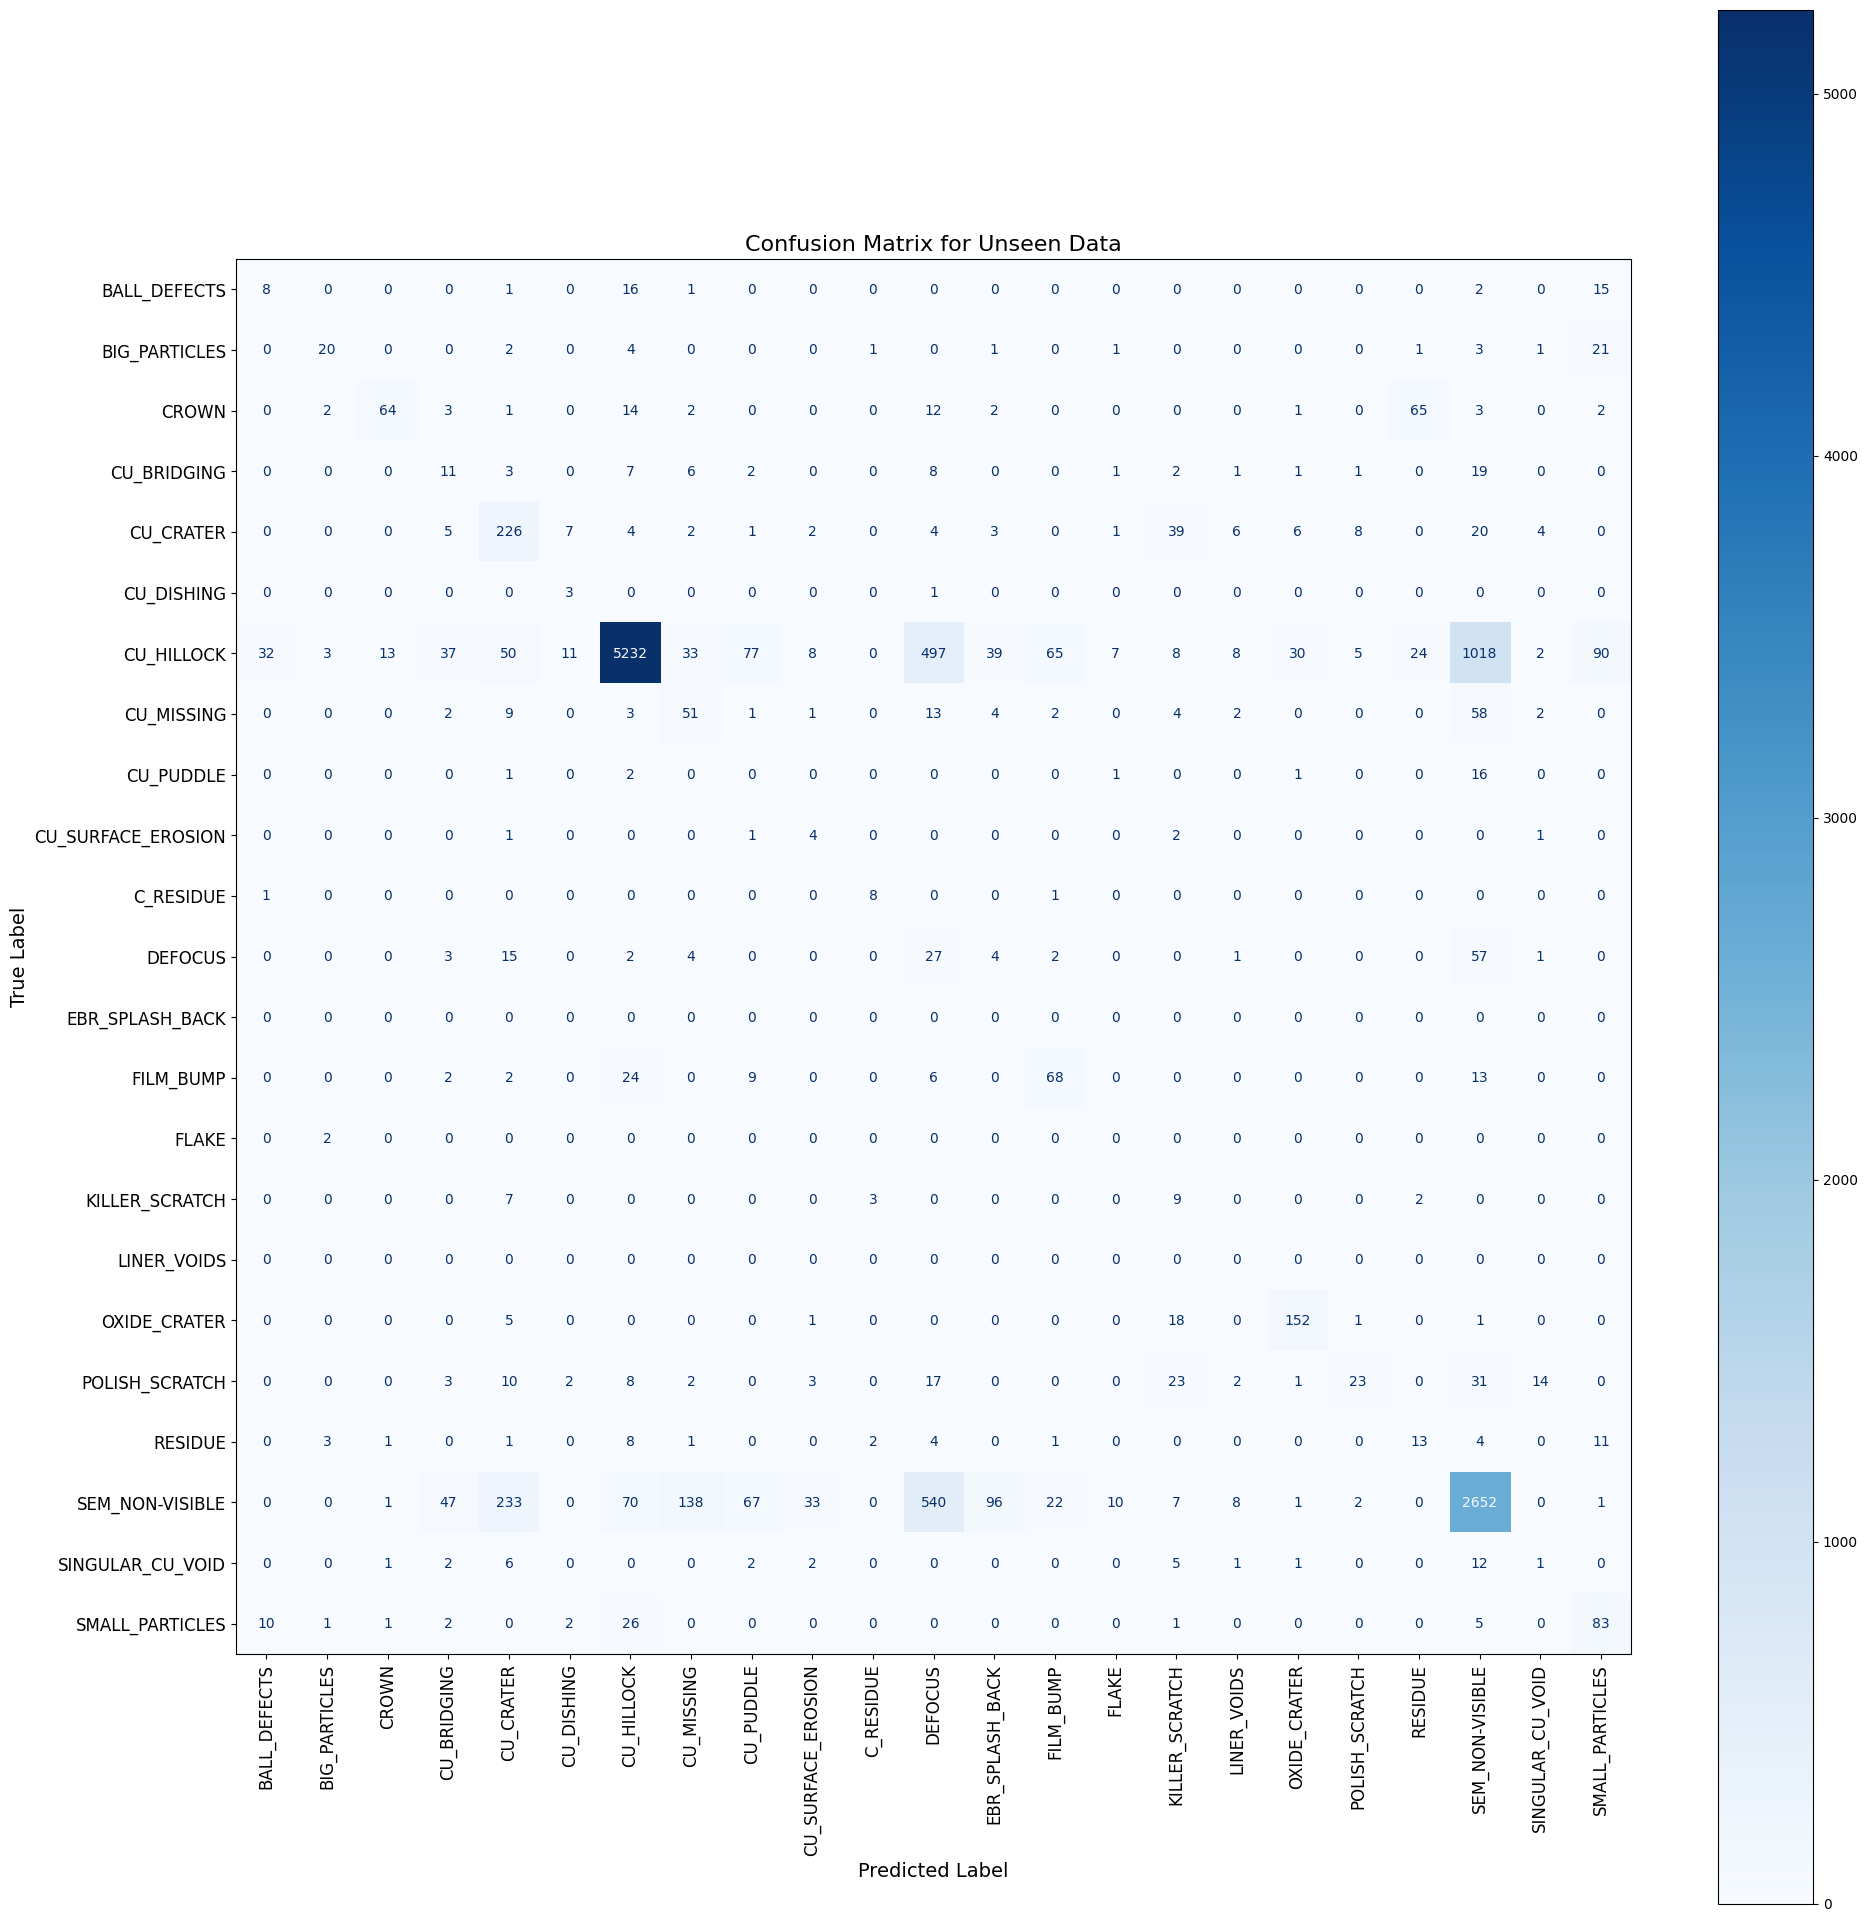

In [11]:
# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions, labels=range(len(training_defect_labels)))
plt.figure(figsize=(20, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=training_defect_labels)
disp.plot(cmap="Blues", values_format='d', ax=plt.gca())
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title("Confusion Matrix for Unseen Data", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.tight_layout()
plt.show()

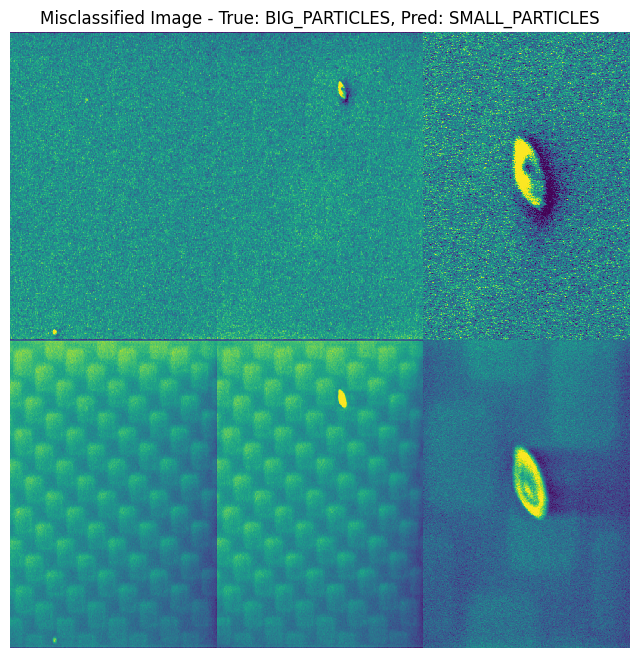

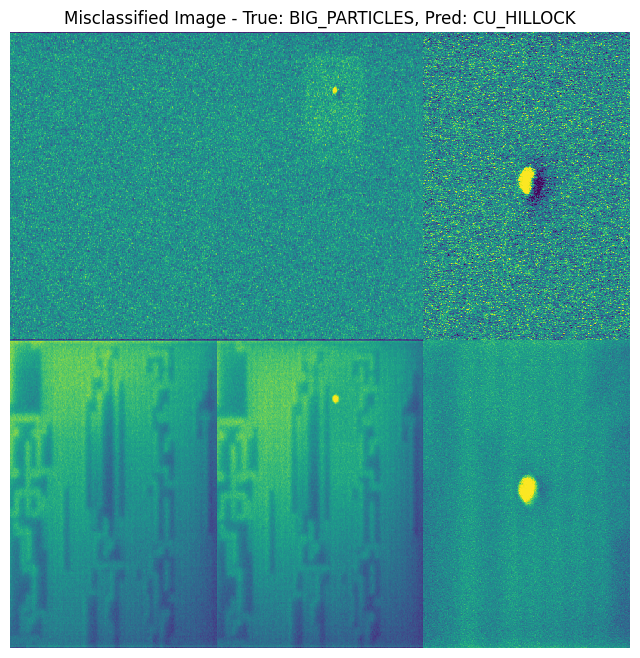

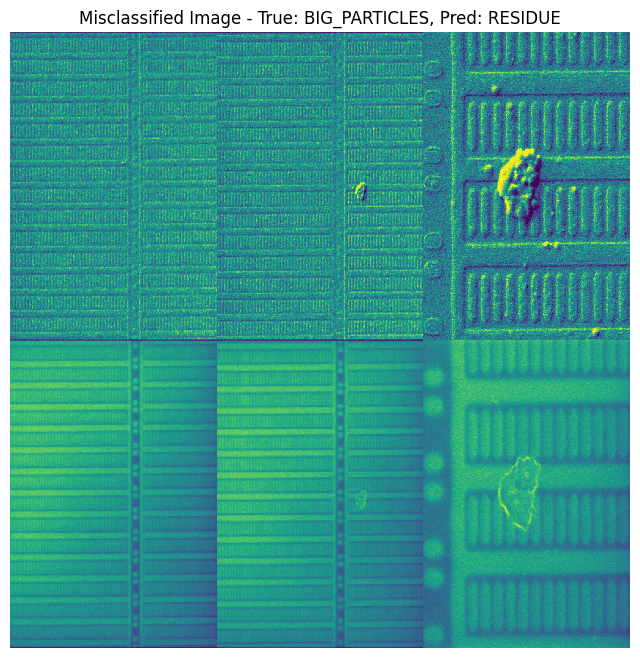

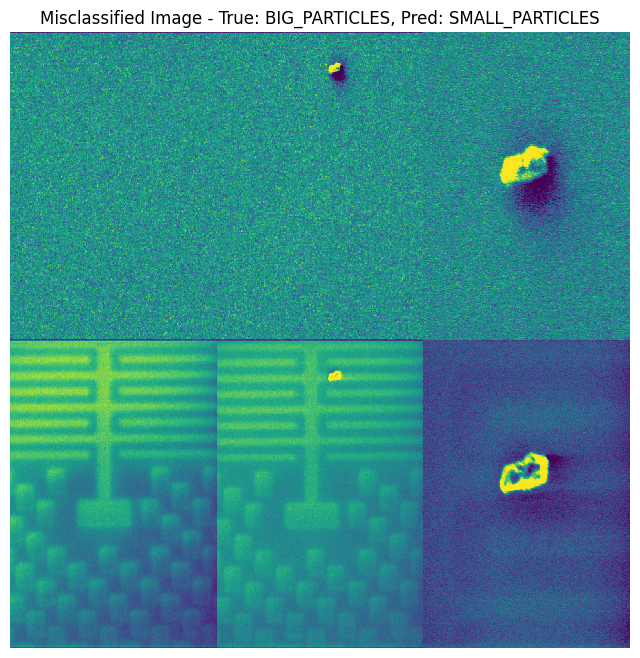

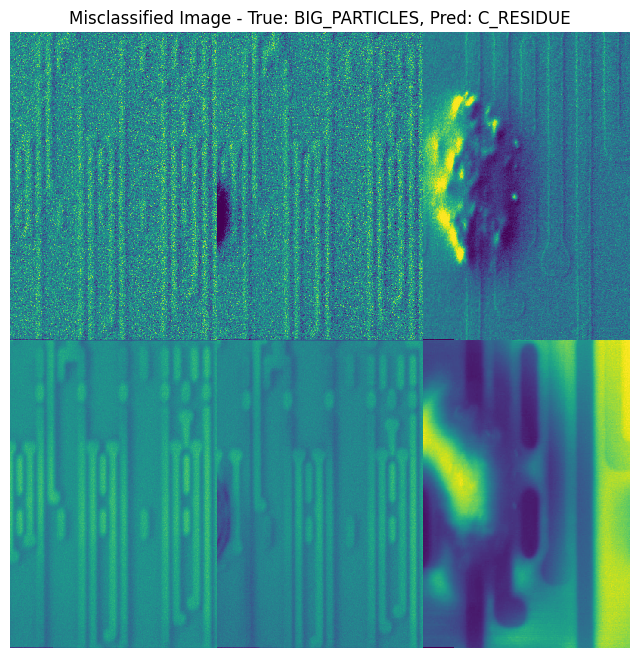

In [10]:
output_folder = "Heatmap_unseen"
os.makedirs(output_folder, exist_ok=True)

def generate_heatmap(image, true_label, pred_label, title, index):
    heatmap = image.mean(dim=0).cpu().numpy()  # Aggregate across channels
    plt.figure(figsize=(8, 8))
    sns.heatmap(heatmap, cmap="viridis", cbar=False)
    plt.title(f"{title} - True: {training_defect_labels[true_label]}, Pred: {training_defect_labels[pred_label]}")
    plt.axis("off")
    save_path = os.path.join(output_folder, f"misclassified_{index + 1}.png")
    plt.savefig(save_path, bbox_inches="tight")
 
# Select 5 misclassified images
misclassified_count = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(unseen_loader):
        images = images.to(device)
        labels = labels.to(device)
        _, out2 = model(images)
        preds = torch.argmax(out2, axis=1)
 
        for i in range(images.size(0)):
            if preds[i] != labels[i]:
                generate_heatmap(images[i], labels[i].item(), preds[i].item(), "Misclassified Image", misclassified_count)
                misclassified_count += 1

                if misclassified_count >= 5:
                    break

        if misclassified_count >= 5:
            break